# Inference and Spherical Coding

This notebook demonstrates the basic idea of Spherical Coding in compressing trajectory data on the NGSIM-101 dataset.

## Load the trajectory data, as usual

In [5]:
import numpy as np
import pickle 
from matplotlib import pyplot as plt 
trajectory_file = open("trajectories.pyo", "rb")
trajs = pickle.load(trajectory_file)
y_vec = np.array(trajs['y_vec'])
t_vec = np.array(trajs['t_vec'])
del trajs
trajectory_file.close()
del trajectory_file

In [6]:
y_vec.shape

(200, 350)

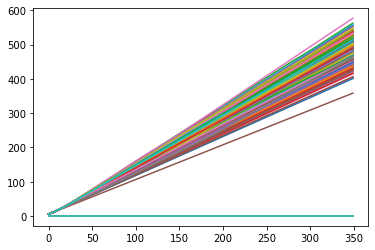

In [7]:
for traj in range(y_vec.shape[0]):
    plt.plot(y_vec[traj])

This is the sample trajectory dataset

Let's generate exemplary observations stream

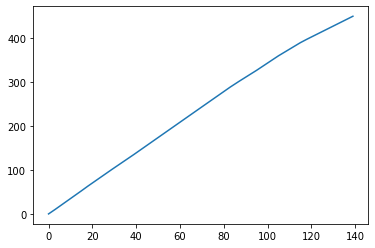

In [3]:
y_test = y_vec[8,:140]
plt.plot(y_test)

## Let's try Spline basis first

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


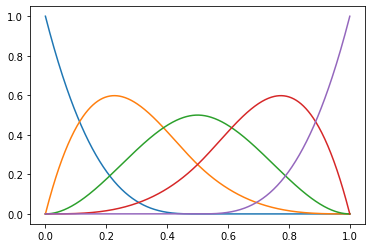

In [4]:
import skfda

# Spline basis
n_basis = 5
basis = skfda.representation.basis.BSpline(n_basis=n_basis)
basis.plot()

Convert data to the spline basis

In [5]:
fdgry = skfda.FDataGrid(y_vec, t_vec)
fdgry_in_splines = fdgry.to_basis(basis)
y_coeffs = fdgry_in_splines.coefficients
friendly_basis = np.zeros((n_basis, t_vec.shape[0]))
for i in range(n_basis):
    friendly_basis[i,:] = fdgry_in_splines.basis.evaluate(t_vec)[i].reshape(-1)

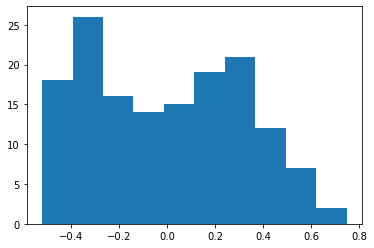

In [6]:
for i in range(1):
    y_r = y_coeffs[i] @ friendly_basis
    plt.hist(y_vec[i] - y_r)

Seems like the reconstruction error is pretty adequate with 5 basis

## Learning the prior distribution

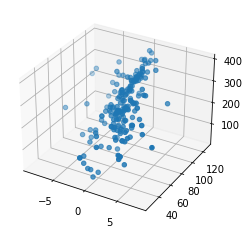

In [7]:
# Visualizing the first three components
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(y_coeffs[:,0], y_coeffs[:,1], y_coeffs[:,2])

In [8]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
bandwidth_candidates = 10 ** np.linspace(1,10,100) # 10^x from -1 to 1
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidth_candidates}, cv=LeaveOneOut())
grid.fit(y_coeffs)
#kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(y_coeffs)
#plt.hist(kde.score_samples(y_coeffs))

GridSearchCV(cv=LeaveOneOut(), estimator=KernelDensity(),
             param_grid={'bandwidth': array([1.00000000e+01, 1.23284674e+01, 1.51991108e+01, 1.87381742e+01,
       2.31012970e+01, 2.84803587e+01, 3.51119173e+01, 4.32876128e+01,
       5.33669923e+01, 6.57933225e+01, 8.11130831e+01, 1.00000000e+02,
       1.23284674e+02, 1.51991108e+02, 1.87381742e+02, 2.31012970e+02,
       2.84803587e+02, 3.511191...
       8.11130831e+07, 1.00000000e+08, 1.23284674e+08, 1.51991108e+08,
       1.87381742e+08, 2.31012970e+08, 2.84803587e+08, 3.51119173e+08,
       4.32876128e+08, 5.33669923e+08, 6.57933225e+08, 8.11130831e+08,
       1.00000000e+09, 1.23284674e+09, 1.51991108e+09, 1.87381742e+09,
       2.31012970e+09, 2.84803587e+09, 3.51119173e+09, 4.32876128e+09,
       5.33669923e+09, 6.57933225e+09, 8.11130831e+09, 1.00000000e+10])})

In [9]:
grid.best_params_

{'bandwidth': 15.199110829529339}

In [10]:
kde = KernelDensity(kernel='gaussian', bandwidth=15.12).fit(y_coeffs)

In [11]:
# Save the KDE so that we don't have to learn from the data the next time the algorithm is run
with open('kde.pyo', 'wb') as f:
    pickle.dump(kde, f, pickle.HIGHEST_PROTOCOL)
print('The file has been saved successfully!')

The file has been saved successfully!


In [12]:
y_test.shape

(140,)

## Sequential Importance Resampling (SIR) of the Posterior Distribution

In [13]:
friendly_basis.shape

(5, 150)

In [14]:
from scipy.stats import norm 
def likelihood(z, theta, t):
    reconstructed_trajectory = theta.T @ friendly_basis 
    #print('Mean: ', reconstructed_trajectory[t])
    #print('Test: ', z)
    #raise Exception("LALALA")
    return norm.pdf(z, loc=reconstructed_trajectory[t], scale=3.0) # scale is the std

In [15]:
# Low variance resampling
def lvr(particles, weights): # requires normalized weights first
    # return: new particles with equal weights
    M = particles.shape[0] # number of particles
    new_particles = np.zeros_like(particles)
    # new_particles_weight = np.ones((M,)) / M 
    # W = np.sum(weights)
    r = np.random.rand() / M # get a random number between 0 and 1/M
    c = weights[0]
    i = 0
    for m in range(M):
        U = r + m/M
        while U>c:
            i+=1
            c+=weights[i]
        new_particles[m] = particles[i]
    return new_particles


In [16]:
# Test the LVR
pars = np.array([1,3,5,7,9])
wghs = np.array([0.1, 0.4, 0.1, 0.1, 0.3])
lvr(pars, wghs)

array([3, 3, 5, 9, 9])

## Selective Broadcasting Filter

In [19]:
n_particles = 5000 
map_particle_available = False

# Step 1: generate a bunch of particles from the prior distribution
particles = kde.sample(n_particles, random_state=6969)
weights = np.ones((n_particles,)) / n_particles
map_components_log = np.zeros((y_test.shape[0], particles.shape[1]))
weights_variance_log = np.zeros((y_test.shape[0],))
measurement_likelihood_log = np.zeros((y_test.shape[0],))
error_log = np.zeros((y_test.shape[0],))
broadcast_log = np.zeros((y_test.shape[0],))

for t in range(y_test.shape[0]):
    # When measurement arrives, calculate the importance weights first
    weights_normalization_coeff = 0
    for j in range(weights.shape[0]):
        measurement_likelihood = likelihood(y_test[t], particles[j,:], t)
        weights[j] = measurement_likelihood
        weights_normalization_coeff += weights[j]
        measurement_likelihood_log[t] += measurement_likelihood

    # print(t, measurement_likelihood)

    # Normalization all the weights
    for j in range(weights.shape[0]):
        weights[j] = weights[j] / weights_normalization_coeff
    
    if not map_particle_available: # first assignment of map_particle_value
        # Get the index of the particle with largest weight, that will be our maximum-a-posteriori estimate 
        map_particle_index = np.argmax(weights)
        map_particle_value = particles[map_particle_index]
        map_components_log[t,:] = map_particle_value
        map_particle_available = True
        
    error_log[t] = np.abs(((map_particle_value) @ friendly_basis)[t] - y_test[t])
    
    if error_log[t] > 3.0:
        map_particle_index = np.argmax(weights)
        map_particle_value = particles[map_particle_index]
        map_components_log[t,:] = map_particle_value
        broadcast_log[t] = 1
    
    # Resample the particles according to the particle weights
    if measurement_likelihood_log[t] < 100:
        particles = lvr(particles, weights)
        weights = np.ones((n_particles,)) / n_particles

    weights_variance_log[t] = np.var(weights)

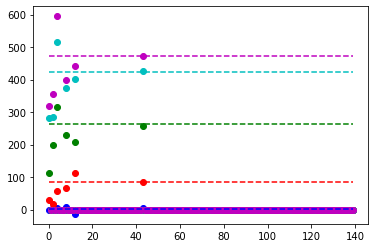

In [20]:
plt.plot(map_components_log[:,0],'bo')
plt.plot(map_components_log[:,1],'ro')
plt.plot(map_components_log[:,2],'go')
plt.plot(map_components_log[:,3],'co')
plt.plot(map_components_log[:,4],'mo')
plt.plot(np.tile(y_coeffs[8,0],140),'b--')
plt.plot(np.tile(y_coeffs[8,1],140),'r--')
plt.plot(np.tile(y_coeffs[8,2],140),'g--')
plt.plot(np.tile(y_coeffs[8,3],140),'c--')
plt.plot(np.tile(y_coeffs[8,4],140),'m--')

## Particle Filter

In [21]:
n_particles = 5000 
map_particle_available = False

# Step 1: generate a bunch of particles from the prior distribution
particles = kde.sample(n_particles, random_state=6969)
weights = np.ones((n_particles,)) / n_particles
map_components_log = np.zeros((y_test.shape[0], particles.shape[1]))
weights_variance_log = np.zeros((y_test.shape[0],))
measurement_likelihood_log = np.zeros((y_test.shape[0],))
error_log = np.zeros((y_test.shape[0],))
broadcast_log = np.zeros((y_test.shape[0],))

for t in range(y_test.shape[0]):
    # When measurement arrives, calculate the importance weights first
    weights_normalization_coeff = 0
    for j in range(weights.shape[0]):
        measurement_likelihood = likelihood(y_test[t], particles[j,:], t)
        weights[j] = measurement_likelihood
        weights_normalization_coeff += weights[j]
        measurement_likelihood_log[t] += measurement_likelihood

    # print(t, measurement_likelihood)

    # Normalization all the weights
    for j in range(weights.shape[0]):
        weights[j] = weights[j] / weights_normalization_coeff
    

    map_particle_index = np.argmax(weights)
    map_particle_value = particles[map_particle_index]
    map_components_log[t,:] = map_particle_value
    map_particle_available = True
    error_log[t] = np.abs(((map_particle_value) @ friendly_basis)[t] - y_test[t])
    
    # Resample the particles according to the particle weights
    if measurement_likelihood_log[t] < 100:
        particles = lvr(particles, weights)
        weights = np.ones((n_particles,)) / n_particles

    weights_variance_log[t] = np.var(weights)

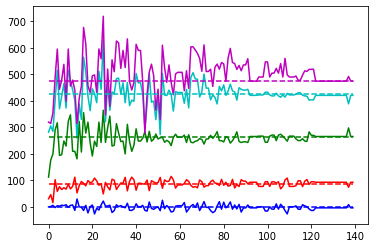

In [22]:
plt.plot(map_components_log[:,0],'b')
plt.plot(map_components_log[:,1],'r')
plt.plot(map_components_log[:,2],'g')
plt.plot(map_components_log[:,3],'c')
plt.plot(map_components_log[:,4],'m')
plt.plot(np.tile(y_coeffs[8,0],140),'b--')
plt.plot(np.tile(y_coeffs[8,1],140),'r--')
plt.plot(np.tile(y_coeffs[8,2],140),'g--')
plt.plot(np.tile(y_coeffs[8,3],140),'c--')
plt.plot(np.tile(y_coeffs[8,4],140),'m--')

## Analysis Charts

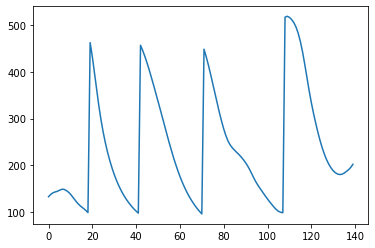

In [23]:
plt.plot(measurement_likelihood_log) # the higher, the better

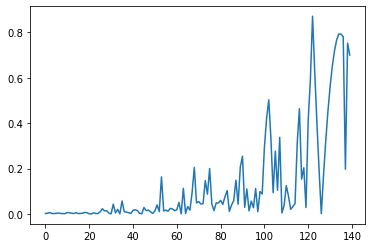

In [24]:
plt.plot(error_log)

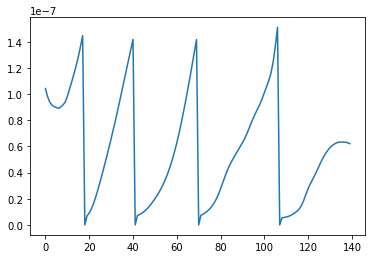

In [25]:
plt.plot(weights_variance_log)

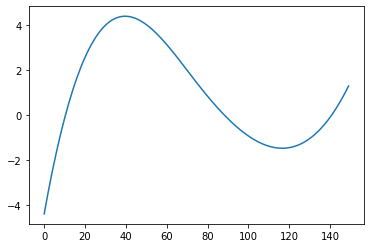

In [26]:
predicted_traj = plt.plot(map_particle_value @ friendly_basis - y_coeffs[8] @ friendly_basis)

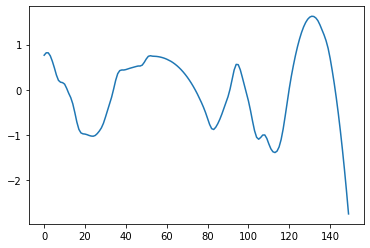

In [27]:
predicted_traj = plt.plot(y_coeffs[8] @ friendly_basis - y_vec[8])

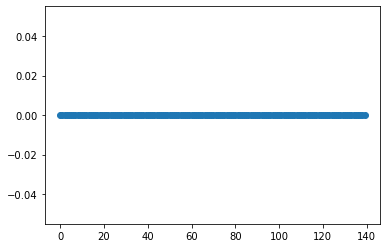

In [28]:
plt.plot(broadcast_log, 'o')

In [29]:
broadcast_log.sum()

0.0

## Spherical codes

### Determining the lattice size

First we find the size of the distribution lattice, which is a 5D sphere with diameter 1m. As a consequence, all representation points belonging to the same lattice should not give an error larger than 1m. The following code demonstrates the idea.

Note that for B-spline basis, the maximum value of the basis value is already 1, so any representation vector whose norm is at most 1 will give an error at most 1m. 

The precise formula is:

$ ||a|| = \frac{h_{max}}{\max_t \Phi(t)} $

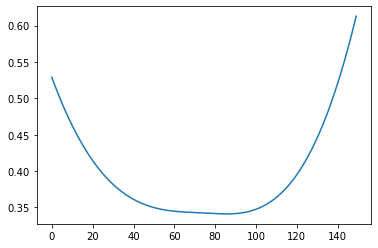

In [17]:
delta_betwn_two_pts = np.random.rand(5,)
delta_betwn_two_pts = delta_betwn_two_pts / np.linalg.norm(delta_betwn_two_pts)
error_in_time_domain = delta_betwn_two_pts.reshape((1,5)) @ friendly_basis
plt.plot(error_in_time_domain[0])

So the error stays less than 1m. As we predicted.

### Inferential Spherical Coding (ISC)

First of all, the whole idea is similar to delta compression: as the estimation of the representation vector $a$ gets better with observations arriving, we will subsequently broadcast the change to other vehicles, which is the delta compared to the last estimate. All MAP estimates start from the prior's mean $\overline{a}$, then gradually moves to the corresponding generating representation vector $a^*$.

Encoding the radial component should be simple: we send a 1 if we want to move to the next annulus of lattice in the outward radial direction. We send a 0 if we want to move in inward radial direction. Overall, the less common the trajectory is, the more bits we have to send (in multiple attempts) to other vehicles. Vice-versa, because most trajectories can be represented close to the mean, we expect to send little bits to determine the "correct" annulus $a^*$ is in.

In [20]:
from scipy.stats import norm 
from coding import huffman
import sys 

This is a helper function to "stitch" a line segment to become a circle: 

In [126]:
def angular_minus(a,b):
    d = np.mod(a - b, np.pi * 2)
    return (d > np.pi) * (np.pi * 2 - d) + (d <= np.pi) * d

In [152]:
n_particles = 5000 
map_particle_available = False

# Step 1: generate a bunch of particles from the prior distribution
particles = kde.sample(n_particles, random_state=6969)
weights = np.ones((n_particles,)) / n_particles
map_components_log = np.zeros((y_test.shape[0], particles.shape[1]))
weights_variance_log = np.zeros((y_test.shape[0],))
measurement_likelihood_log = np.zeros((y_test.shape[0],))
error_log = np.zeros((y_test.shape[0],))
broadcast_log = np.zeros((y_test.shape[0],))
bits_log = []

lattice_size = 1/np.sqrt(np.shape(particles[0])[0]) # 1/sqrt(5) in case of 5 basis components

for t in range(y_test.shape[0]):
    # When measurement arrives, calculate the importance weights first
    weights_normalization_coeff = 0
    for j in range(weights.shape[0]):
        measurement_likelihood = likelihood(y_test[t], particles[j,:], t)
        weights[j] = measurement_likelihood
        weights_normalization_coeff += weights[j]
        measurement_likelihood_log[t] += measurement_likelihood

    # print(t, measurement_likelihood)

    # Normalization all the weights
    for j in range(weights.shape[0]):
        weights[j] = weights[j] / weights_normalization_coeff
    
    if not map_particle_available: # first assignment of map_particle_value
        # Get the index of the particle with largest weight, that will be our maximum-a-posteriori estimate 
        map_particle_index = np.argmax(weights)
        map_particle_value = particles[map_particle_index]
        mean_particle = map_particle_value.copy()
        # Intialization of variables at the beginning of the inference process
        phi = np.zeros((np.shape(mean_particle)[0]-1,))
        q_vector = np.zeros_like(mean_particle)
        map_components_log[t,:] = map_particle_value
        map_particle_available = True
        
        
    error_log[t] = np.abs(((map_particle_value) @ friendly_basis)[t] - y_test[t])
    map_particle_index = np.argmax(weights)
    map_particle_value_new = particles[map_particle_index]
    
    if error_log[t] > 1.0: # if the prediction from MAP deviates up to 3ft from the actual observations
        # we will have to broadcast an update so that our fellows can adjust accordingly
        alpha_new = map_particle_value_new - mean_particle # alpha_1 in your notes
        # estimate the spherical coordinates of the new alpha particle
        r_new = np.linalg.norm(alpha_new)
        phi_new = np.zeros((np.shape(mean_particle)[0]-1,))
        phiq = np.zeros((np.shape(mean_particle)[0]-1,))
        for i in range(np.shape(mean_particle)[0]-1):
            phi_new[i] = np.arccos(alpha_new[i]/r_new)
        # quantize the coordinates
        rq = np.round(r_new / lattice_size)
        r_new_q = rq * lattice_size
        angular_lattice_size = lattice_size / r_new_q # rad/lattice
        total_angular_lattice = np.floor(2*np.pi/angular_lattice_size)
        for i in range(np.shape(mean_particle)[0]-1):
            phiq[i] = np.floor(phi_new[i]/angular_lattice_size)
        
        q_vector_new = np.concatenate((np.array([rq]), phiq), axis=0)
        # Now we have the two quantized vector: q_vector and q_vector new, we will encode the delta change in bits

        # For the radius component, the bits to be transmit is precisely rq_new - rq_old
        r_bits = q_vector_new[0] - q_vector[0]
        r_entropy = np.log2(np.abs(r_bits))
        # For the remaining angular components, we will build a Huffman's code whose proba distribution depends on the current q_vector
        # the intuition is that the MAP estimate will mostly follow a continuous path so it makes sense to use shorter codewords for lattices on its path

        phi_bits = np.zeros_like(phi_new)
        phi_entropy = 0
        for d in range(np.shape(mean_particle)[0]-1): # for each angular dimension
            # The first step is to generate a probability distribution for the NEW angular lattices
            p_lattice = np.zeros((int(total_angular_lattice),))
            for i in range(int(total_angular_lattice)):
                # p_lattice[i] = norm.pdf(angular_minus(i * angular_lattice_size, phi[d]), 0, np.pi/3) # normal distribution model 
                p_lattice[i] = 1 # uniform distribution model
            p_lattice = p_lattice / np.linalg.norm(p_lattice) # normalize so that it is a proba distribution
            
            # Next step: to construct Huffman code for each angular lattice (of each individual dimension)
            code = huffman.HuffmanCode(p_lattice.tolist())
            spherical_code = code.compute_code()
            phi_bits[d] = int(spherical_code[int(phiq[d])], 2) # convert a string of binary to int
            phi_entropy += np.log2(phi_bits[d])

        print('Radial/angular delta vector: {} / {}'.format(r_bits, phi_bits))
        print('Angular distance between trans (% of circle): {}'.format(angular_minus(phi_new, phi) * 100 / (2*np.pi)))
        print('Radial bits / Angular bits: {:.2f}/{:.2f}'.format(r_entropy, phi_entropy))
        print('W/O Before/after compression: {:.0f} -> {:.0f} ({:.2f}%) bits'.format(5 * 64, r_entropy + phi_entropy, (r_entropy + phi_entropy) / (5 * 64) * 100))
        print('--- END OF TRANSMISSION ATTEMPT ---')
        map_components_log[t,:] = map_particle_value
        broadcast_log[t] = 1
        bits_log.append(r_entropy + phi_entropy)

        # Assign new values to current values
        map_particle_value = map_particle_value_new
        q_vector = q_vector_new.copy() 
        phi = phi_new.copy() 

        # sys.exit()
    
    # Resample the particles according to the particle weights
    if measurement_likelihood_log[t] < 100:
        particles = lvr(particles, weights)
        weights = np.ones((n_particles,)) / n_particles

    weights_variance_log[t] = np.var(weights)

Radial/angular delta vector: 157.0 / [307. 339. 485. 357.]
Angular distance between trans (% of circle): [24.65721324 21.48643385  6.64781924 19.61225607]
Radial bits / Angular bits: 7.29/34.07
W/O Before/after compression: 320 -> 41 (12.93%) bits
--- END OF TRANSMISSION ATTEMPT ---
Radial/angular delta vector: 56.0 / [901. 855. 425. 892.]
Angular distance between trans (% of circle): [0.61258366 5.97038914 0.13339178 4.8975408 ]
Radial bits / Angular bits: 5.81/38.09
W/O Before/after compression: 320 -> 44 (13.72%) bits
--- END OF TRANSMISSION ATTEMPT ---
Radial/angular delta vector: 414.0 / [1215. 1383. 1648. 1493.]
Angular distance between trans (% of circle): [1.09448683 6.58150416 7.59144788 6.43361101]
Radial bits / Angular bits: 8.69/41.91
W/O Before/after compression: 320 -> 51 (15.81%) bits
--- END OF TRANSMISSION ATTEMPT ---
Radial/angular delta vector: -229.0 / [2001.  500.  589.  605.]
Angular distance between trans (% of circle): [0.37426176 0.01970464 3.3105875  1.3191271

Mean (STD): 47.73 (+-2.88)


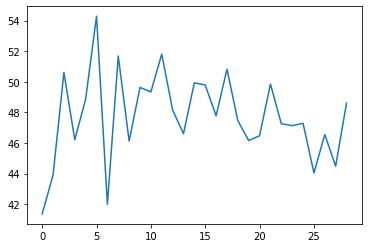

In [154]:
# Uniform distribution
plt.plot(np.array(bits_log))
print('Mean (STD): {:.2f} (+-{:.2f})'.format(np.average(np.array(bits_log)), np.std(np.array(bits_log))))

Mean (STD): 43.90 (+-3.84)


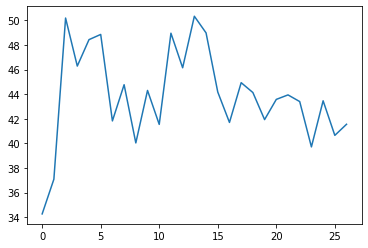

In [151]:
# Gaussian distribution with STD = pi/3 
plt.plot(np.array(bits_log2))
print('Mean (STD): {:.2f} (+-{:.2f})'.format(np.average(np.array(bits_log2)), np.std(np.array(bits_log2))))